In [1]:
from datascience import *
%matplotlib inline
path_data = '../../../../data/'
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

In [2]:
def bootstrap_median(original_sample, label, replications):
    
    """Returns an array of bootstrapped sample medians:
    original_sample: table containing the original sample
    label: label of column containing the variable
    replications: number of bootstrap samples
    """
    
    just_one_column = original_sample.select(label)
    medians = make_array()
    for i in np.arange(replications):
        bootstrap_sample = just_one_column.sample()
        resampled_median = percentile(50, bootstrap_sample.column(0))
        medians = np.append(medians, resampled_median)
        
    return medians

In [3]:
def bootstrap_mean(original_sample, label, replications):
    
    """Returns an array of bootstrapped sample means:
    original_sample: table containing the original sample
    label: label of column containing the variable
    replications: number of bootstrap samples
    """
    
    just_one_column = original_sample.select(label)
    means = make_array()
    for i in np.arange(replications):
        bootstrap_sample = just_one_column.sample()
        resampled_mean = np.mean(bootstrap_sample.column(0))
        means = np.append(means, resampled_mean)
        
    return means

In [4]:
def bootstrap_proportion(original_sample, label, replications):
    
    """Returns an array of bootstrapped sample proportions:
    original_sample: table containing the original sample
    label: label of column containing the Boolean variable
    replications: number of bootstrap samples
    """
    
    just_one_column = original_sample.select(label)
    proportions = make_array()
    for i in np.arange(replications):
        bootstrap_sample = just_one_column.sample()
        resample_array = bootstrap_sample.column(0)
        resampled_proportion = np.count_nonzero(resample_array)/len(resample_array)
        proportions = np.append(proportions, resampled_proportion)
        
    return proportions

### Using Confidence Intervals ###
A confidence interval has a single purpose – to estimate an unknown parameter based on data in a random sample. In the last section, we said that the interval (36%, 42%) was an approximate 95% confidence interval for the percent of smokers among mothers in the population. That was a formal way of saying that by our estimate, the percent of smokers among the mothers in the population was somewhere between 36% and 42%, and that our process of estimation is correct about 95% of the time.

It is important to resist the impulse to use confidence intervals for other purposes. For example, recall that we calculated the interval (26.9 years, 27.6 years) as an approximate 95% confidence interval for the average age of mothers in the population. A dismayingly common misuse of the interval is to conclude that about 95% of the women were between 26.9 years and 27.6 years old. You don't need to know much about confidence intervals to see that this can't be right – you wouldn't expect 95% of mothers to all be within a few months of each other in age. Indeed, the histogram of the sampled ages shows quite a bit of variation.

In [5]:
baby = Table.read_table(path_data + 'baby.csv')

/home/choldgraf/anaconda/envs/textbook/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


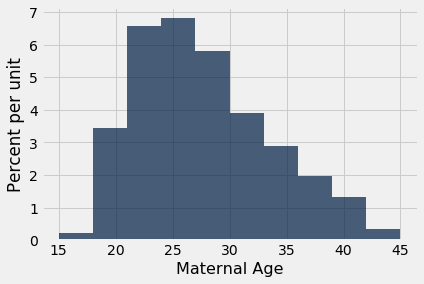

In [6]:
baby.select('Maternal Age').hist()

A small percent of the sampled ages are in the (26.9, 27.6) interval, and you would expect a similar small percent in the population. The interval just estimates one number: the *average* of all the ages in the population.

However, estimating a parameter by confidence intervals does have an important use besides just telling us roughly how big the parameter is. 

### Using a Confidence Interval to Test Hypotheses ###
Our approximate 95% confidence interval for the average age in the population goes from 26.9 years to 27.6 years. Suppose someone wants to test the following hypotheses:

**Null hypothesis.** The average age in the population is 30 years.

**Alternative hypothesis.** The average age in the population is not 30 years.

Then, if you were using the 5% cutoff for the P-value, you would reject the null hypothesis. This is because 30 is not in the 95% confidence interval for the population average. At the 5% level of significance, 30 is not a plausible value for the population average.

This use of confidence intervals is the result of a *duality* between confidence intervals and tests: if you are testing whether or not the population mean is a particular value *x*, and you use the 5% cutoff for the P-value, then you will reject the null hypothesis if *x* is not in your 95% confidence interval for the mean. 

This can be established by statistical theory. In practice, it just boils down to checking whether or not the value specified in the null hypothesis lies in the confidence interval.

If you were using the 1% cutoff for the P-value, you would have to check if the value specified in the null hypothesis lies in a 99% confidence interval for the population mean.

To a rough approximation, these statements are also true for population proportions, provided the sample is large.

While we now have a way of using confidence intervals to test a particular kind of hypothesis, you might wonder about the value of testing whether or not the average age in a population is equal to 30. Indeed, the value isn't clear. But there are some situations in which a test of this kind of hypothesis is both natural and useful.

We will study this in the context of data that are a subset of the information gathered in a randomized controlled trial about treatments for Hodgkin's disease. Hodgkin's disease is a cancer that typically affects young people. The disease is curable but the treatment can be very harsh. The purpose of the trial was to come up with dosage that would cure the cancer but minimize the adverse effects on the patients. 

This table ``hodgkins`` contains data on the effect that the treatment had on the lungs of 22 patients. The columns are:

- Height in cm
- A measure of radiation to the mantle (neck, chest, under arms)
- A measure of chemotherapy
- A score of the health of the lungs at baseline, that is, at the start of the treatment; higher scores correspond to more healthy lungs
- The same score of the health of the lungs, 15 months after treatment

In [7]:
hodgkins = Table.read_table(path_data + 'hodgkins.csv')

In [8]:
hodgkins

height,rad,chemo,base,month15
164,679,180,160.57,87.77
168,311,180,98.24,67.62
173,388,239,129.04,133.33
157,370,168,85.41,81.28
160,468,151,67.94,79.26
170,341,96,150.51,80.97
163,453,134,129.88,69.24
175,529,264,87.45,56.48
185,392,240,149.84,106.99
178,479,216,92.24,73.43


We will compare the baseline and 15-month scores. As each row corresponds to one patient, we say that the sample of baseline scores and the sample of 15-month scores are *paired* - they are not just two sets of 22 values each, but 22 pairs of values, one for each patient.

At a glance, you can see that the 15-month scores tend to be lower than the baseline scores – the sampled patients' lungs seem to be doing worse 15 months after the treatment. This is confirmed by the mostly positive values in the column `drop`, the amount by which the score dropped from baseline to 15 months.

In [9]:
hodgkins = hodgkins.with_column(
    'drop', hodgkins.column('base') - hodgkins.column('month15')
)

In [10]:
hodgkins

height,rad,chemo,base,month15,drop
164,679,180,160.57,87.77,72.8
168,311,180,98.24,67.62,30.62
173,388,239,129.04,133.33,-4.29
157,370,168,85.41,81.28,4.13
160,468,151,67.94,79.26,-11.32
170,341,96,150.51,80.97,69.54
163,453,134,129.88,69.24,60.64
175,529,264,87.45,56.48,30.97
185,392,240,149.84,106.99,42.85
178,479,216,92.24,73.43,18.81


/home/choldgraf/anaconda/envs/textbook/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


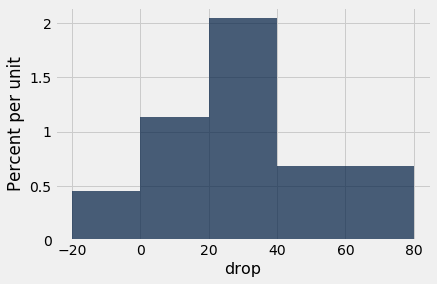

In [11]:
hodgkins.select('drop').hist(bins=np.arange(-20, 81, 20))

In [12]:
np.mean(hodgkins.column('drop'))

28.615909090909096

But could this be the result of chance variation? It really doesn't seem so, but the data are from a random sample. Could it be that in the entire population of patients, the average drop is just 0?

To answer this, we can set up two hypotheses:

**Null hypothesis.** In the population, the average drop is 0.

**Alternative hypothesis.** In the population, the average drop is not 0.

To test this hypothesis with a 1% cutoff for the P-value, let's construct an approximate 99% confidence interval for the average drop in the population.

In [13]:
bstrap_means = bootstrap_mean(hodgkins, 'drop', 10000)

left = percentile(0.5, bstrap_means)
right = percentile(99.5, bstrap_means)

make_array(left, right)

array([17.22636364, 40.54045455])

/home/choldgraf/anaconda/envs/textbook/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


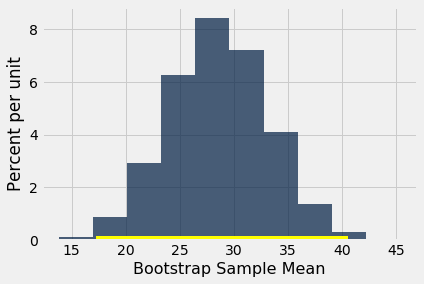

In [14]:
resampled_means = Table().with_column(
    'Bootstrap Sample Mean', bstrap_means
)
resampled_means.hist()
plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);

The 99% confidence interval for the average drop in the population goes from about 17 to about 40. The interval doesn't contain 0. So we reject the null hypothesis.

But notice that we have done better than simply concluding that the average drop in the population isn't 0. We have estimated how big the average drop is. That's a more useful result than just saying, "It's not 0."

**A note on accuracy.** Our confidence interval is quite wide, for two main reasons:
- The confidence level is high (99%).
- The sample size is relatively small compared to those in our earlier examples.

In the next chapter, we will examine how the sample size affects accuracy. We will also examine how the empirical distributions of sample means so often come out bell shaped even though the distributions of the underlying data are not bell shaped at all.

### Endnote ###
The terminology of a field usually comes from the leading researchers in that field. [Brad Efron](https://en.wikipedia.org/wiki/Bradley_Efron), who first proposed the bootstrap technique, used a term that has [American origins](https://en.wikipedia.org/wiki/Bootstrapping). Not to be outdone, Chinese statisticians have [proposed their own method](http://econpapers.repec.org/article/eeestapro/v_3a37_3ay_3a1998_3ai_3a4_3ap_3a321-329.htm).